# Numerical Benchmarks

In [7]:
import sys
sys.path.insert(0, '../../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm

from loss_functions import *
from optimization import *
from quantum_channel import *
from quantum_tools import *
from experimental import *
from spam import *

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Recover SPAM and Map

### Generate True Model, Full POVM and Inital

In [71]:
def generate_spam_benchmark(n=3, c1=1, c2=1):
    d = 2**n
    spam_target = SPAM(d=d)

    init_target = c1*init_ideal(d) + (1-c1)*spam_target.init
    povm_target = c2*povm_ideal(d) + (1-c2)*spam_target.povm

    spam_target = SPAM(d=d,
                       init = init_target,
                       povm = povm_target)
    
    return spam_target


def generate_spam_data(spam_target, N_spam=None, noise=0):
    n = spam_target.n
    inputs_spam, _ = generate_pauliInput_circuits(n, N_spam)
    N_spam = inputs_spam.shape[0]

    state = tf.repeat(spam_target.init[None,:,:], N_spam, axis=0)
    state = apply_unitary(state, inputs_spam)
    targets_spam = measurement(state, povm = spam_target.povm)

    #add noise
    targets_spam = add_noise_to_probs(targets_spam, noise=noise)
    return inputs_spam, targets_spam


def generate_map_data(channel_target, spam_target, N_map=None, noise=0):
    n = channel_target.n
    inputs_map, _ = generate_pauli_circuits(n = n, 
                                            circuit_target=None,  
                                            trace=False,
                                            N=N_map)
    U_prep, U_basis = inputs_map

    N_map = U_prep.shape[0]
    state = tf.repeat(tf.expand_dims(spam_target.init, axis=0), N_map, axis=0)
    state = apply_unitary(state, U_prep)
    state = channel_target.apply_channel(state)
    targets_map = measurement(state, U_basis, spam_target.povm)
    
    return inputs_map, targets_map


def povm_fidelity(spam_a, spam_b):
    d = spam_a.d
    povm_a, povm_b = spam_a.povm, spam_b.povm
    ab = tf.matmul(povm_a, povm_b)
    ab_sqrt = tf.linalg.sqrtm(ab)
    fidelity = tf.math.reduce_sum(tf.linalg.trace(ab_sqrt))/d
    return fidelity


def model_pipeline(channel_target, noise, N_map=2000):
    # Make Benchmark
    #################################################################################
    n = 3
    d = 2**n
    
    spam_target = generate_spam_benchmark(n=n, c1=0.9, c2=0.9)
    inputs_spam, targets_spam = generate_spam_data(spam_target, N_spam=None, noise=noise)

    inputs_map, targets_map = generate_map_data(channel_target, spam_target, N_map=N_map, noise=noise)
    #################################################################################

    # Fit Models
    #################################################################################
    spam_model = SPAM(d=d,
                      use_corr_mat=True,
                      optimizer = tf.optimizers.Adam(learning_rate=0.01))

    spam_model.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                        num_iter = 300,
                        verbose = False,
                        )

    spam_model.train(inputs = inputs_spam,
                     targets = targets_spam,
                     num_iter = 2000,
                     verbose = False,
                    )

    model = ModelQuantumMap(channel = KrausMap(d = d, 
                                               rank = d**2,
                                               spam = spam_model,
                                              ),
                            loss_function = ProbabilityMSE(),
                            optimizer = tf.optimizers.Adam(learning_rate=0.01),
                            logger = Logger(loss_function = channel_fidelity_loss),
                           )

    model.train(inputs = inputs_map,
                targets = targets_map,
                inputs_val = None,
                targets_val = [channel_target],
                num_iter = 2000,
                N = 500,
                )
    #################################################################################

    return model

## Fit Models

In [72]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

channel_target1 = CompactLindbladMap(d, 2, 1, 0.1)
model1 = model_pipeline(channel_target1, noise=1/100)

channel_target2 = CompactLindbladMap(d, 16, 10000, 0.001)
model2 = model_pipeline(channel_target2, noise=1/100)

channel_target3 = CompactLindbladMap(d, 16, 100, 0.001)
model3 = model_pipeline(channel_target3, noise=1/100)

channel_target4 = CompactLindbladMap(d, 8, 1, 0.01)
model4 = model_pipeline(channel_target4, noise=1/100)

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0010746900373211814


  0%|          | 0/2000 [00:00<?, ?it/s]

None -0.08766725008272647
None -0.36405770992146613
None -0.6735159482911504
None -0.8086018484120181
None -0.8674681434549683
None -0.8987095232116794
None -0.9181625835285483
None -0.9312351103785378
None -0.9406844141003902
None -0.9477375052791984
None -0.9532187316432574
None -0.9576318684503653
None -0.9611589125140163
None -0.9640469345119334
None -0.9664515700657382
None -0.9684918403090088
None -0.9701645685794417
None -0.9716032556356305
None -0.972790249561046
None -0.9738031541716706
None -0.9746848923770415


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0009990514571146735


  0%|          | 0/2000 [00:00<?, ?it/s]

None -0.24120463509324558
None -0.699939740264476
None -0.8902746952707326
None -0.9124733810060293
None -0.9207839921857958
None -0.9264040158521587
None -0.9305985705361863
None -0.9338560298034249
None -0.9362813768451218
None -0.9381893273413873
None -0.9396966854946325
None -0.9408673515922623
None -0.9417847308751873
None -0.9425274006805123
None -0.943135453978599
None -0.9436117797279171
None -0.9439719366141984
None -0.9442416010869857
None -0.9444629019385199
None -0.9446459897407393
None -0.94474643695351


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0009629771976011982


  0%|          | 0/2000 [00:00<?, ?it/s]

None -0.1429426017272639
None -0.4033337287055627
None -0.7262814744664942
None -0.8103171475651014
None -0.8469011405846382
None -0.8723729771972464
None -0.8906390160552897
None -0.9043110655051139
None -0.9149149298499085
None -0.9232812912228633
None -0.9300897896302406
None -0.9356482568598936
None -0.940293732162883
None -0.9441811256892779
None -0.9475201155972534
None -0.9502512252983243
None -0.9526387963015237
None -0.9546062249032833
None -0.9562822636441043
None -0.9577109098388711
None -0.9589485449043355


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0010525087701808297


  0%|          | 0/2000 [00:00<?, ?it/s]

None -0.3598629730893975
None -0.5877237670009524
None -0.7640308547469024
None -0.842149503344178
None -0.8807997600180658
None -0.9034373192487398
None -0.9183700102520553
None -0.9289668206285782
None -0.9368195270944433
None -0.9429766690497478
None -0.9479338476123951
None -0.9519436240060802
None -0.9552869698394804
None -0.9581208129649592
None -0.9605370961663741
None -0.9626314423719662
None -0.9644156473788879
None -0.9660127361095754
None -0.9673914231713336
None -0.9686218627650934
None -0.9697631924848371


In [73]:
spectrum_target1 = channel_spectrum(channel_target1)
spectrum_target2 = channel_spectrum(channel_target2)
spectrum_target3 = channel_spectrum(channel_target3)
spectrum_target4 = channel_spectrum(channel_target4)

spectrum_model1 = channel_spectrum(model1.channel)
spectrum_model2 = channel_spectrum(model2.channel)
spectrum_model3 = channel_spectrum(model3.channel)
spectrum_model4 = channel_spectrum(model4.channel)

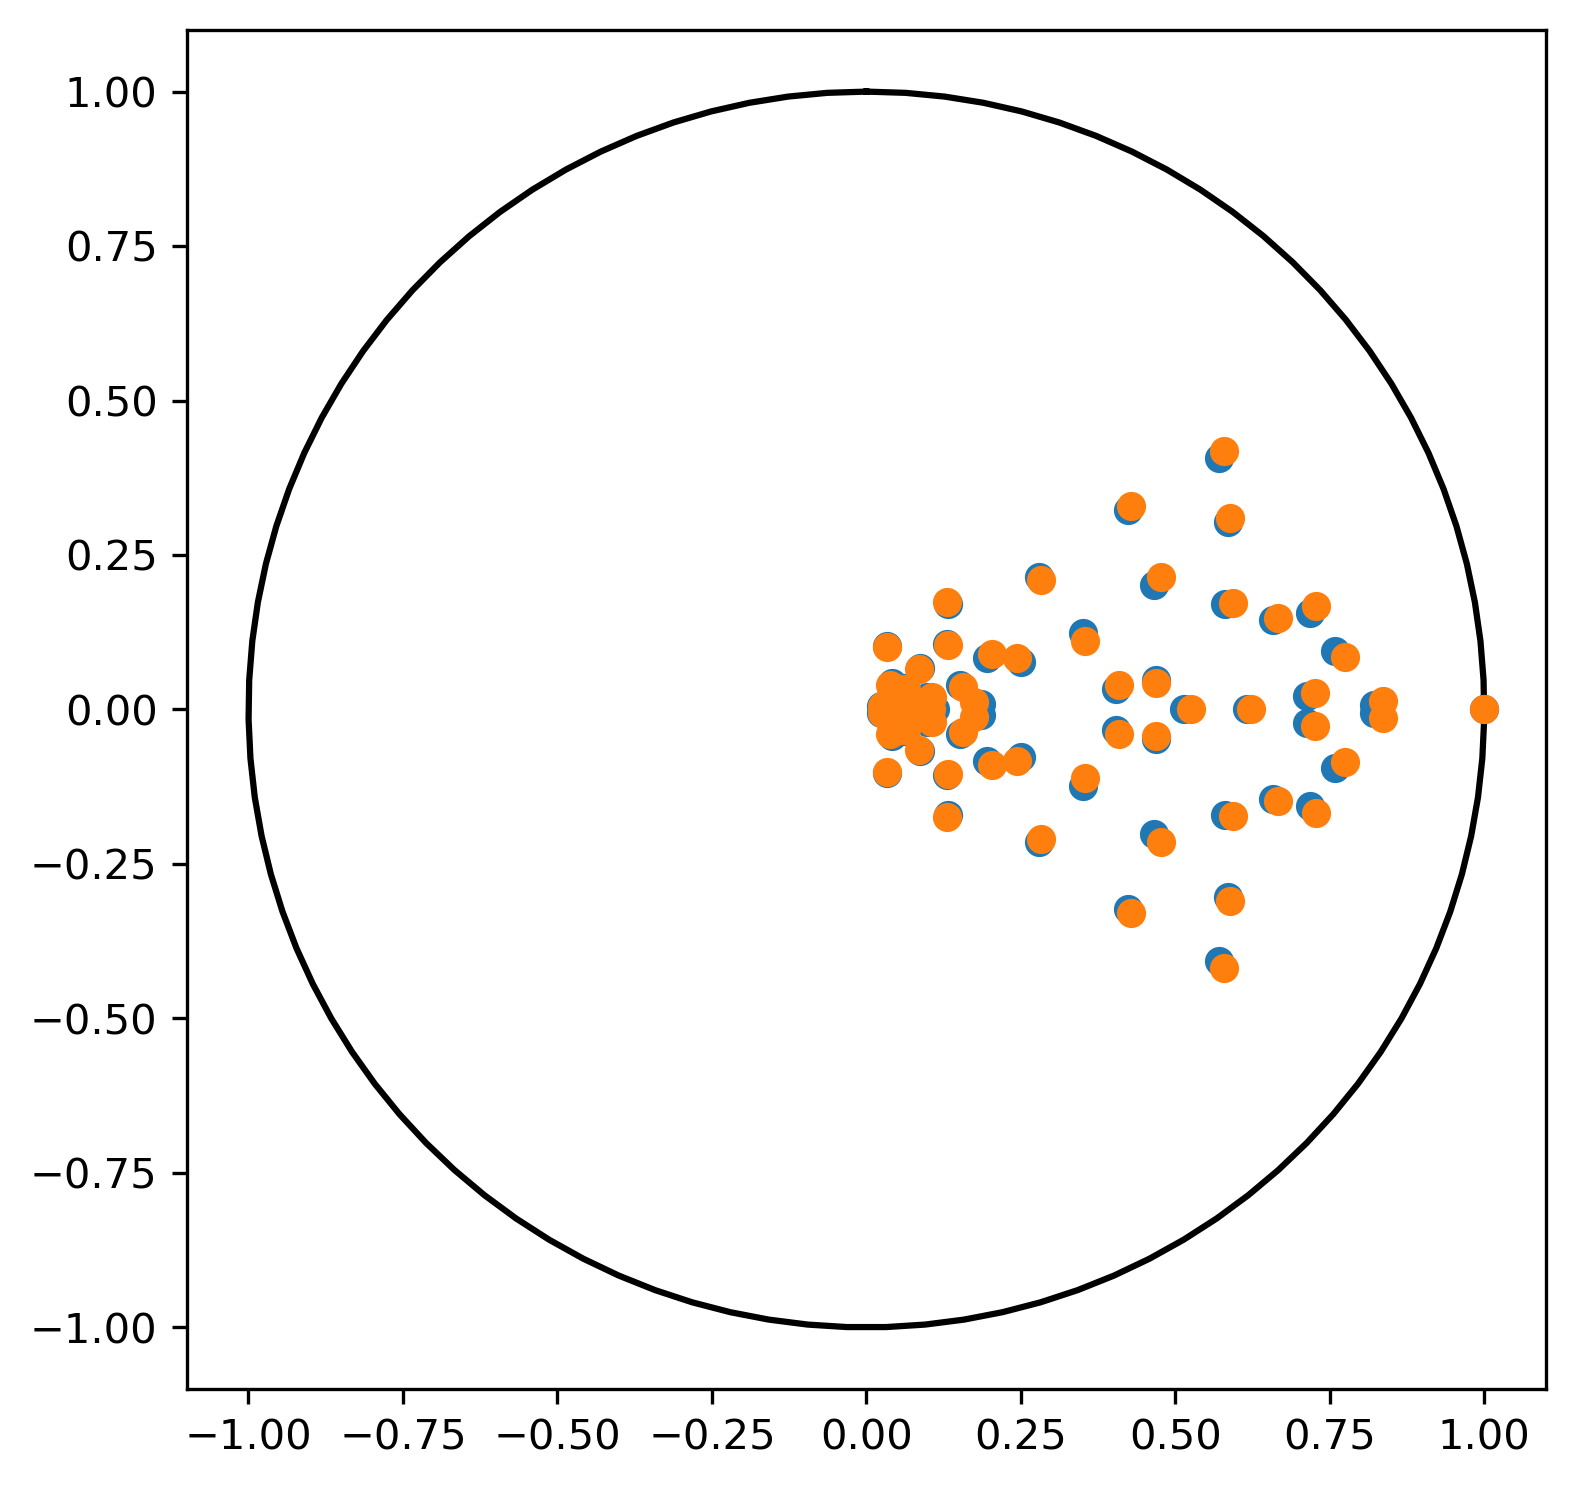

In [74]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum_model1[:,0], spectrum_model1[:,1], "o")
plt.plot(spectrum_target1[:,0], spectrum_target1[:,1], "o")
plt.show()

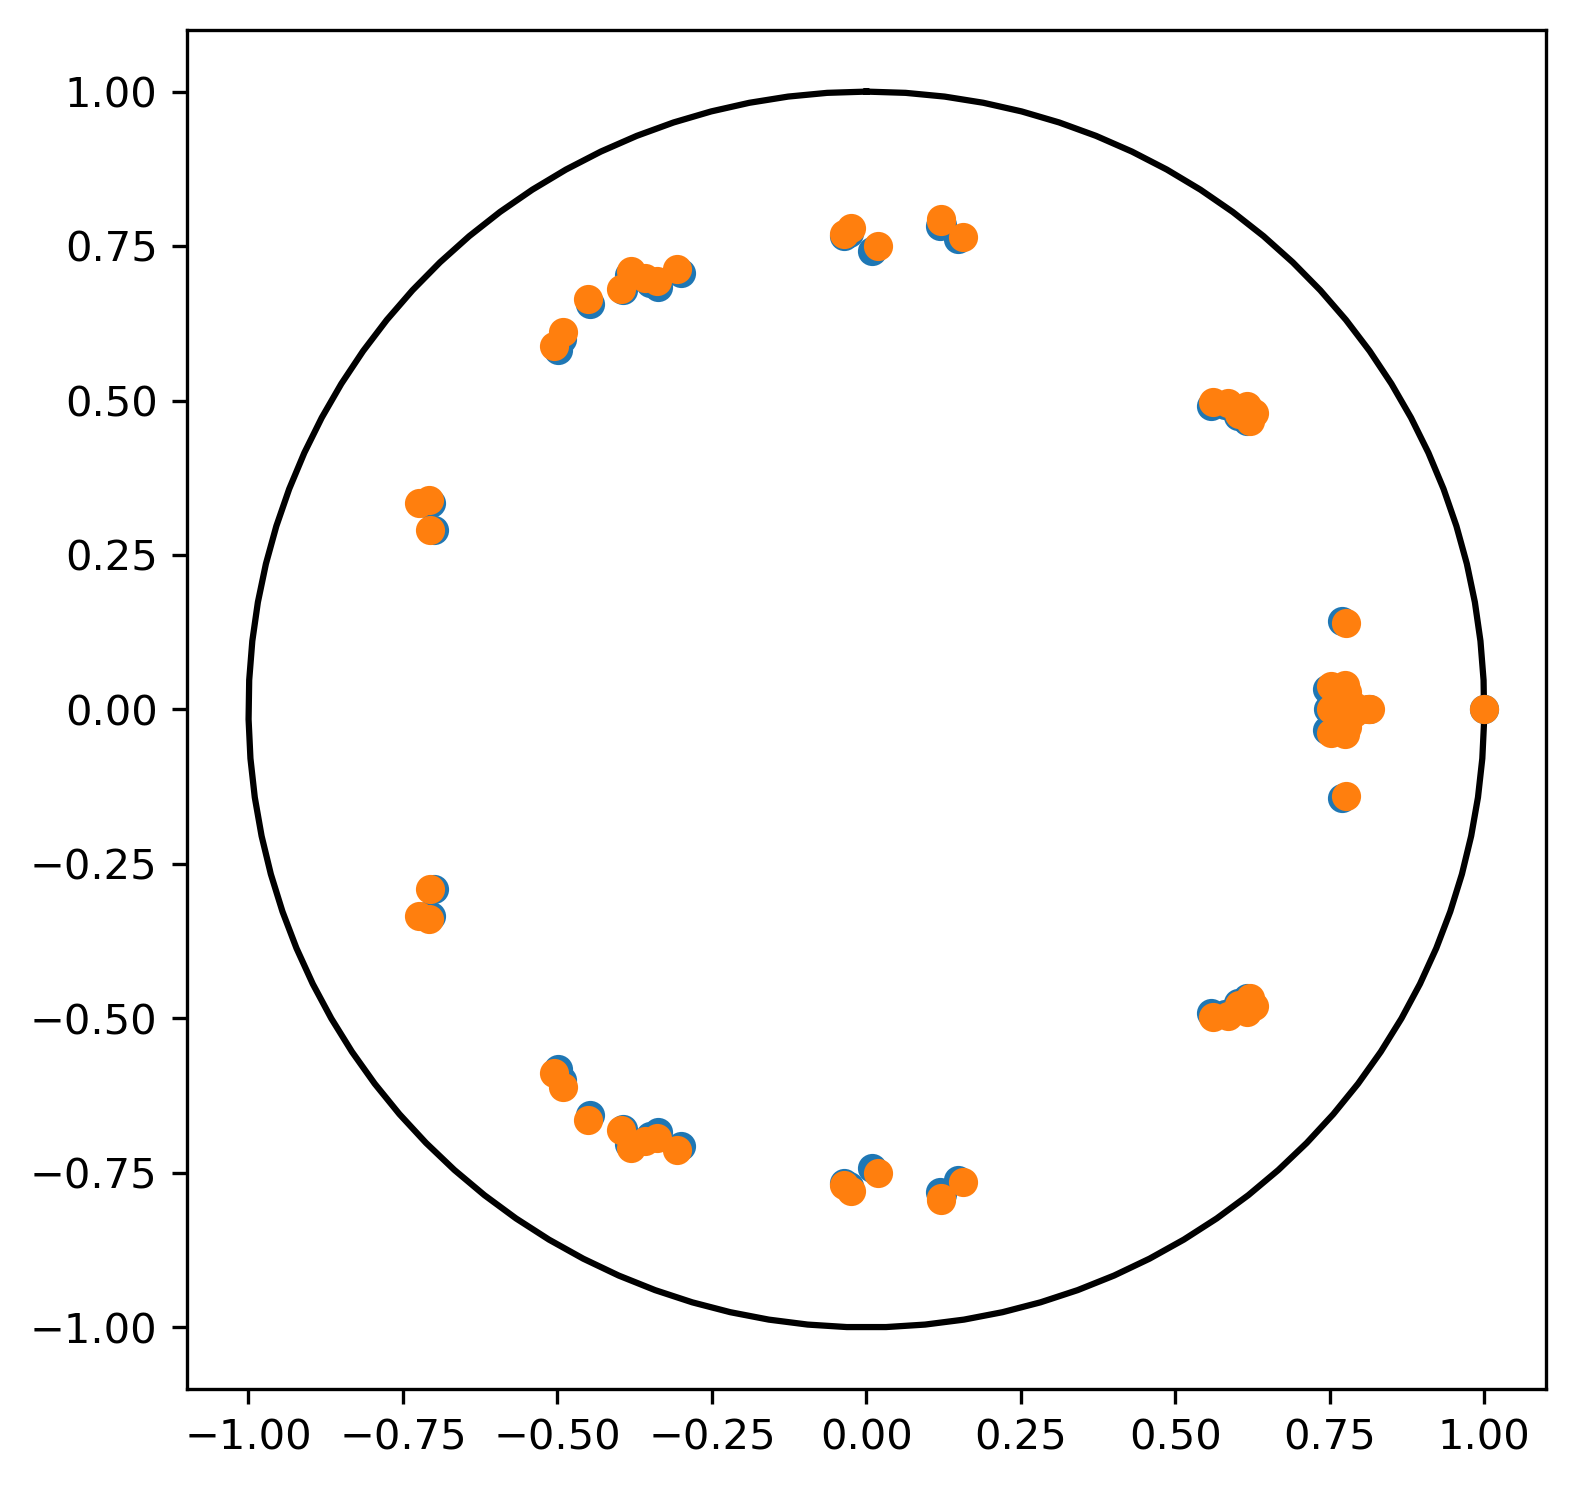

In [75]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum_model2[:,0], spectrum_model2[:,1], "o")
plt.plot(spectrum_target2[:,0], spectrum_target2[:,1], "o")
plt.show()

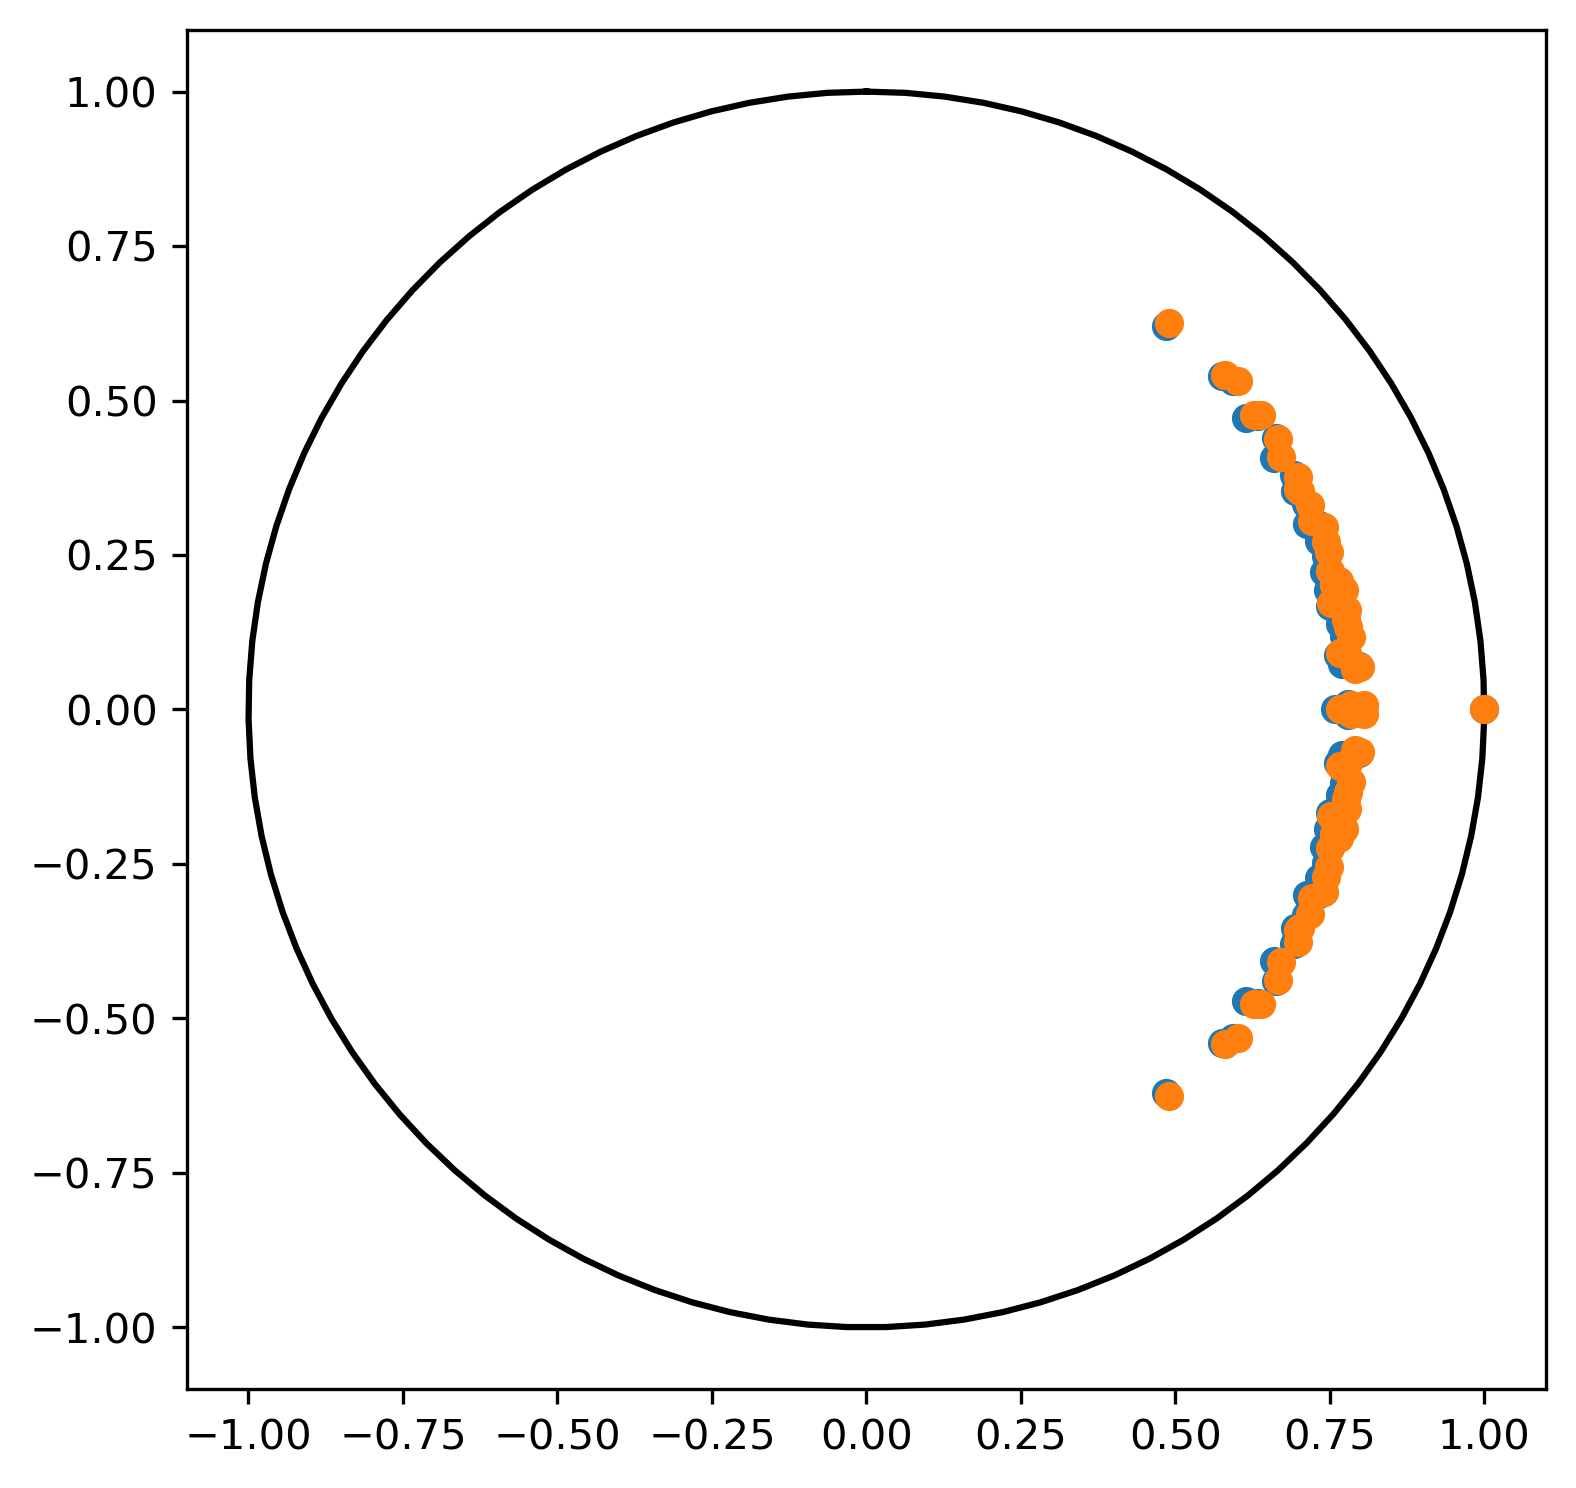

In [76]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum_model3[:,0], spectrum_model3[:,1], "o")
plt.plot(spectrum_target3[:,0], spectrum_target3[:,1], "o")
plt.show()

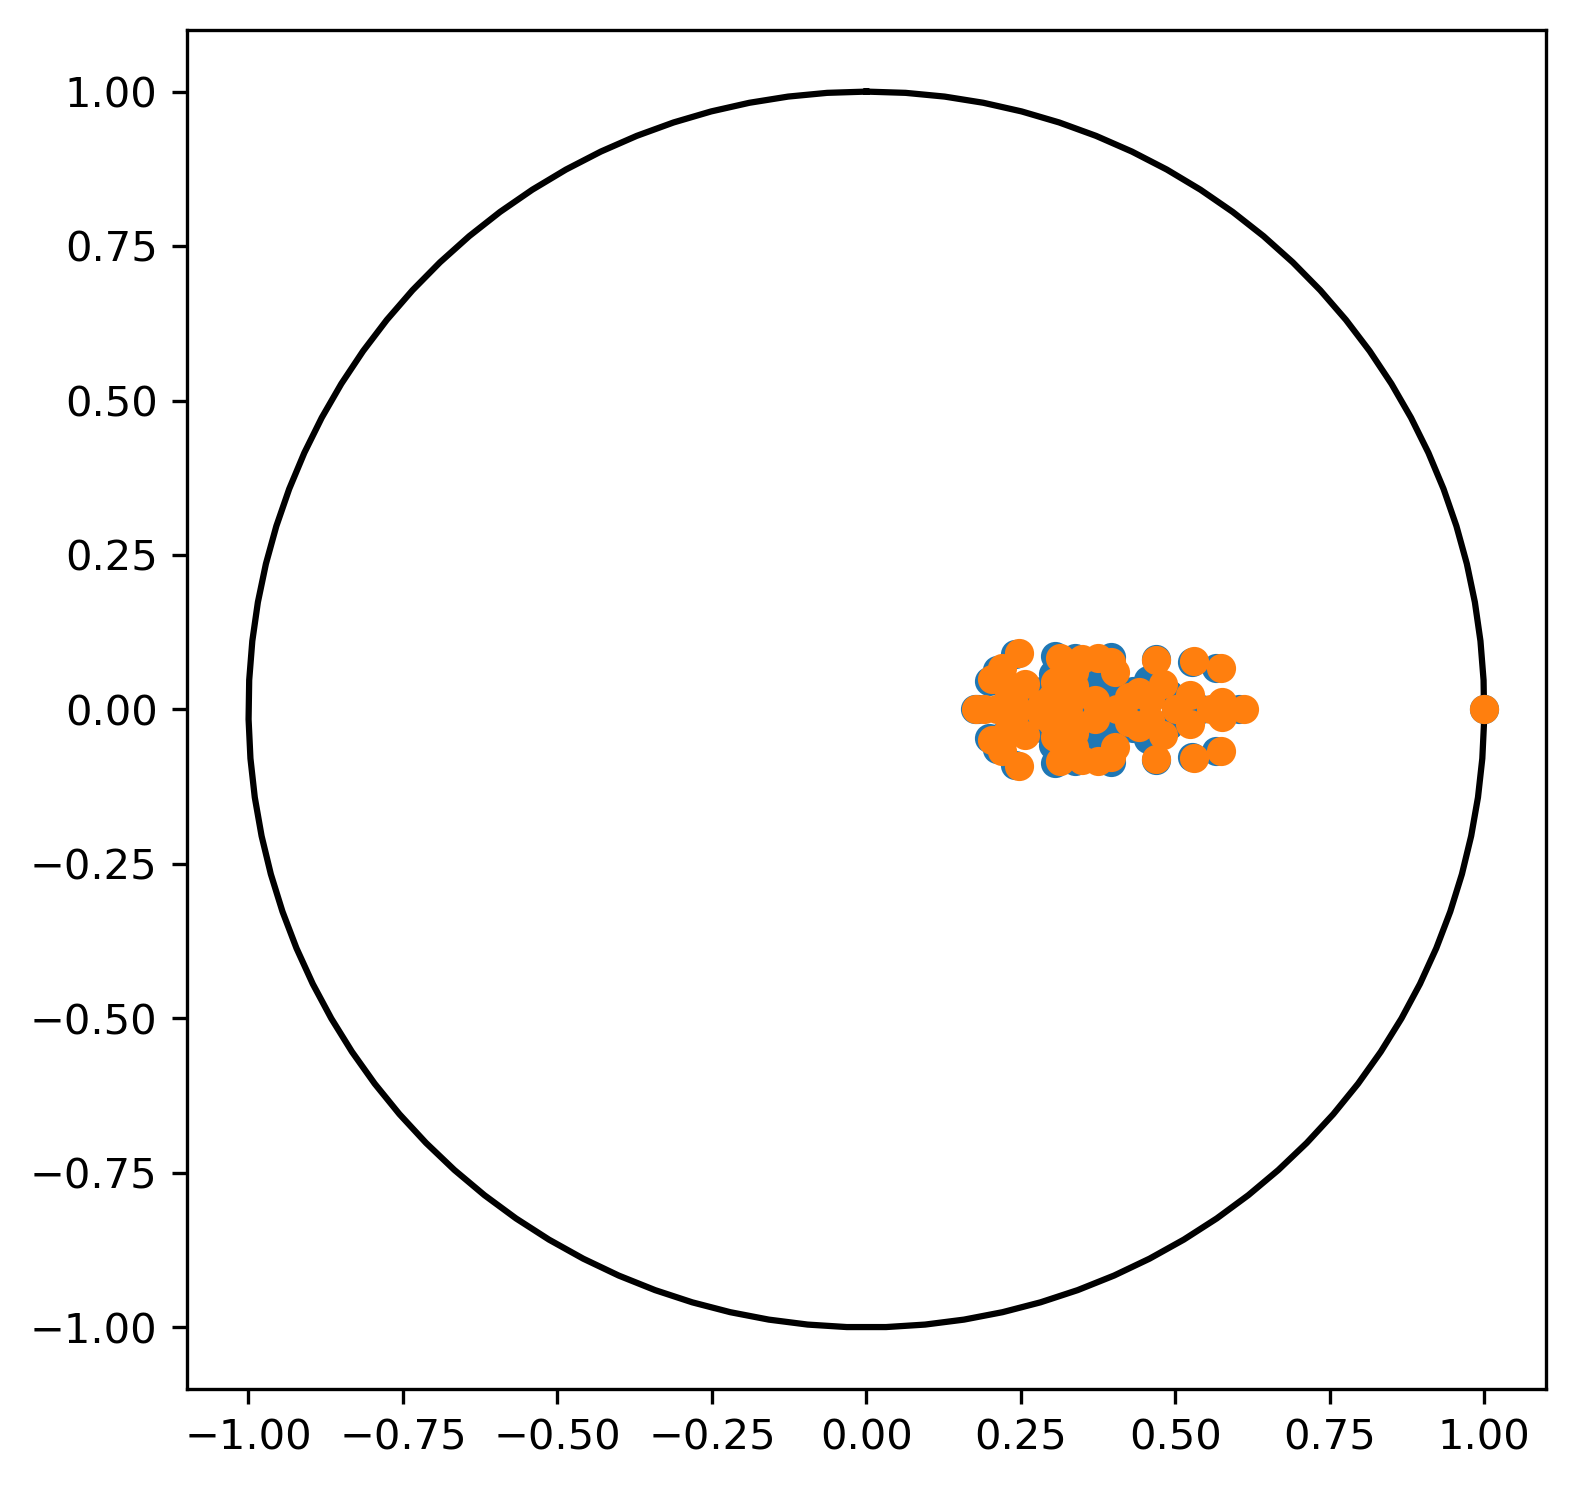

In [77]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum_model4[:,0], spectrum_model4[:,1], "o")
plt.plot(spectrum_target4[:,0], spectrum_target4[:,1], "o")
plt.show()

## Sample and Noise Sensitivity

In [87]:
n = 3
d = 2**n
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

channel_target = CompactLindbladMap(d, 2, 1, 0.1)
model_ns1 = model_pipeline(channel_target, noise=0.1, N_map=250)
model_ns2 = model_pipeline(channel_target, noise=0.01, N_map=1000)
model_ns3 = model_pipeline(channel_target, noise=0.0, N_map=4000)

  0%|          | 0/2000 [00:00<?, ?it/s]

0.04963693701609311


  0%|          | 0/2000 [00:00<?, ?it/s]

None -0.08766725008272647
None -0.3301120732938566
None -0.5725573961900176
None -0.7023095718860848
None -0.7710260943414037
None -0.8116701049080504
None -0.8378565577139405
None -0.8557974841572684
None -0.8686517570371047
None -0.8781767134448966
None -0.8854206536043102
None -0.8910434230351426
None -0.8954786286882842
None -0.8990217895818926
None -0.9018808699666618
None -0.9042064300951497
None -0.9061102262528891
None -0.9076770255883755
None -0.9089722603697037
None -0.9100471434593674
None -0.9109421872024563


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0009444733752442113


  0%|          | 0/2000 [00:00<?, ?it/s]

None -0.09478711264550965
None -0.3904785171104288
None -0.6843199644317857
None -0.8082363688197397
None -0.8649941942999628
None -0.8962407024113541
None -0.9158376135065406
None -0.9291757450760724
None -0.9387978895945276
None -0.9460598308044892
None -0.9516582819035218
None -0.9560905896160319
None -0.9597496001864722
None -0.9626746904803528
None -0.9650923685369645
None -0.9671490604017894
None -0.9688598610376595
None -0.9703261476448559
None -0.9715161198047079
None -0.9725469693413259
None -0.9734609771965386


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0005704642365119804


  0%|          | 0/2000 [00:00<?, ?it/s]

None -0.09750918177153953
None -0.3866703436883027
None -0.6841608599031582
None -0.8124499221449184
None -0.8698967511177345
None -0.9012930770159046
None -0.9209192087790954
None -0.9344257437099451
None -0.9440407399190628
None -0.9513314200737722
None -0.9569586209492691
None -0.9613983349477385
None -0.9649348752228708
None -0.9678354677616697
None -0.9701614902141142
None -0.9720982988253862
None -0.973743494878253
None -0.9751032764366278
None -0.9762611501781095
None -0.9772268845780613
None -0.9780018999299231


In [88]:
spectrum_target = channel_spectrum(channel_target)

spectrum_model1 = channel_spectrum(model_ns1.channel)
spectrum_model2 = channel_spectrum(model_ns2.channel)
spectrum_model3 = channel_spectrum(model_ns3.channel)

C:\Users\krist\AppData\Local\Temp\ipykernel_4564\2171647831.py:12: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001C5093187C0> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(["_","Ground Truth"], loc="lower left")


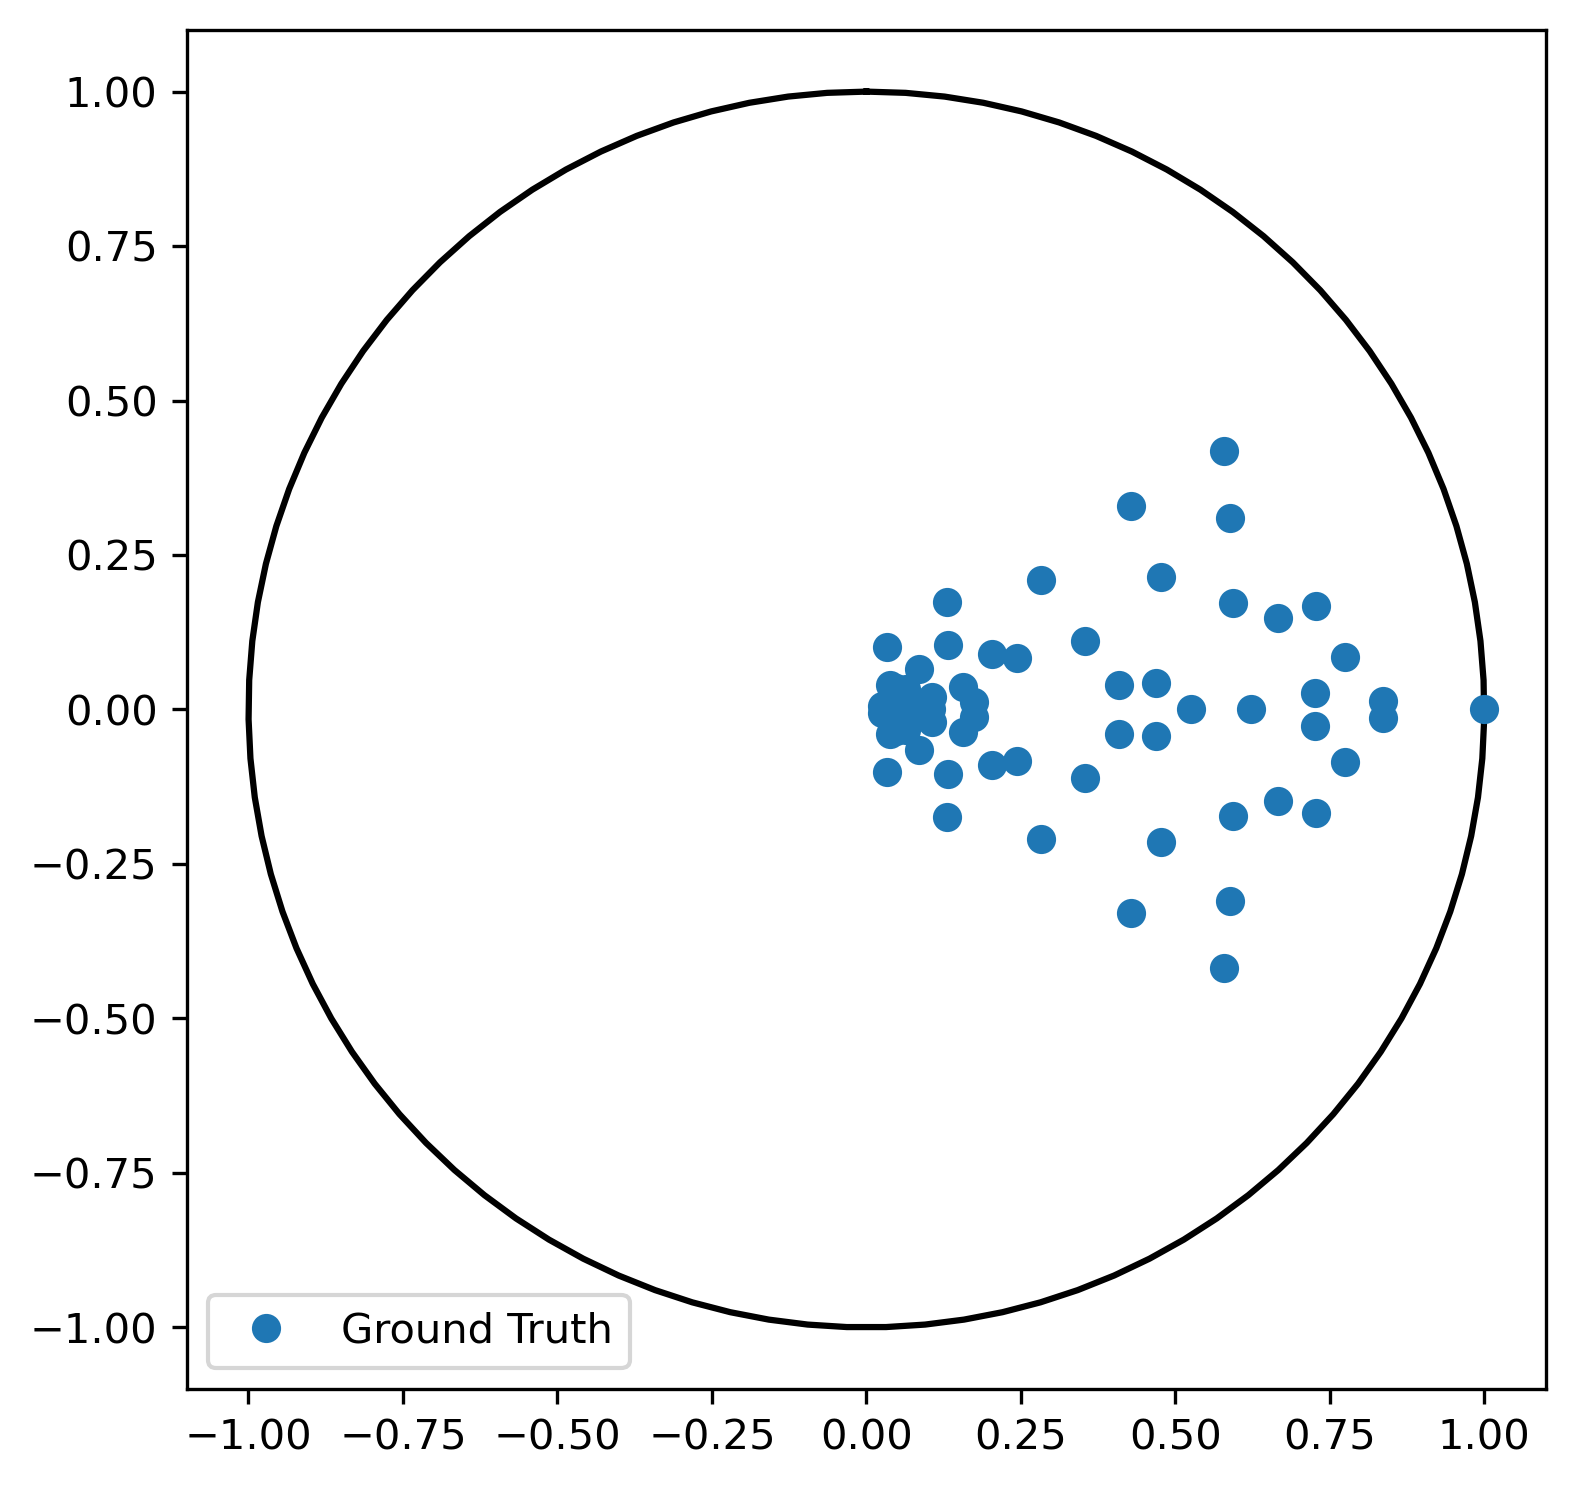

In [89]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum_target[:,0], spectrum_target[:,1], "o")
#plt.plot(spectrum_model1[:,0], spectrum_model1[:,1], "o")
#plt.plot(spectrum_model2[:,0], spectrum_model2[:,1], "o")
#plt.plot(spectrum_model3[:,0], spectrum_model3[:,1], "o")
plt.legend(["_","Ground Truth"], loc="lower left")
plt.show()

C:\Users\krist\AppData\Local\Temp\ipykernel_4564\1544188263.py:12: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001C501F7E890> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(["_","Ground Truth", "Shots=$10^2$, Samples=250"], loc="lower left")


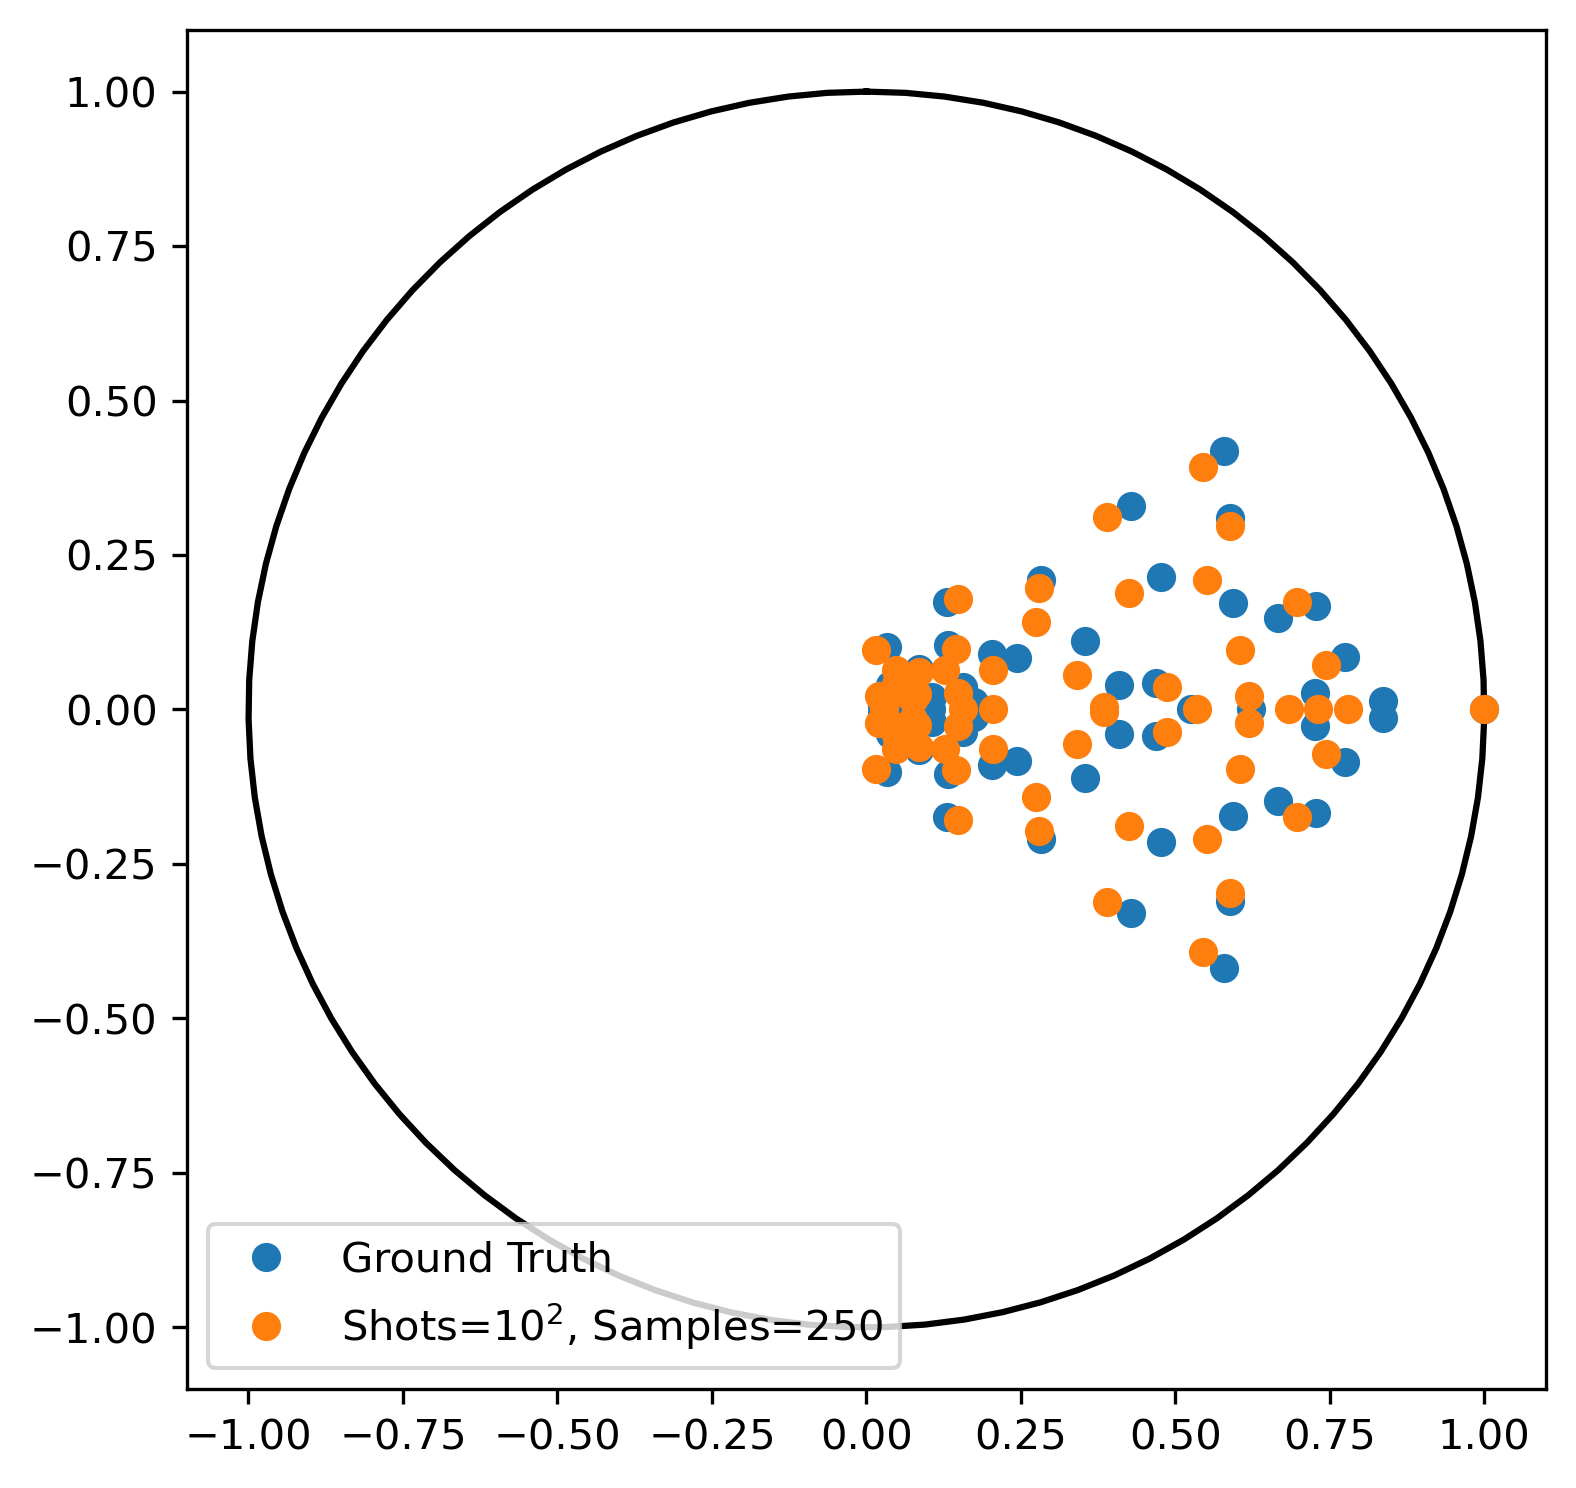

In [90]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum_target[:,0], spectrum_target[:,1], "o")
plt.plot(spectrum_model1[:,0], spectrum_model1[:,1], "o")
#plt.plot(spectrum_model2[:,0], spectrum_model2[:,1], "o")
#plt.plot(spectrum_model3[:,0], spectrum_model3[:,1], "o")
plt.legend(["_","Ground Truth", "Shots=$10^2$, Samples=250"], loc="lower left")
plt.show()

C:\Users\krist\AppData\Local\Temp\ipykernel_4564\3160920600.py:12: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001C50A61BAC0> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(["_","Shots=$10^4$, Samples=1000"], loc="lower left")


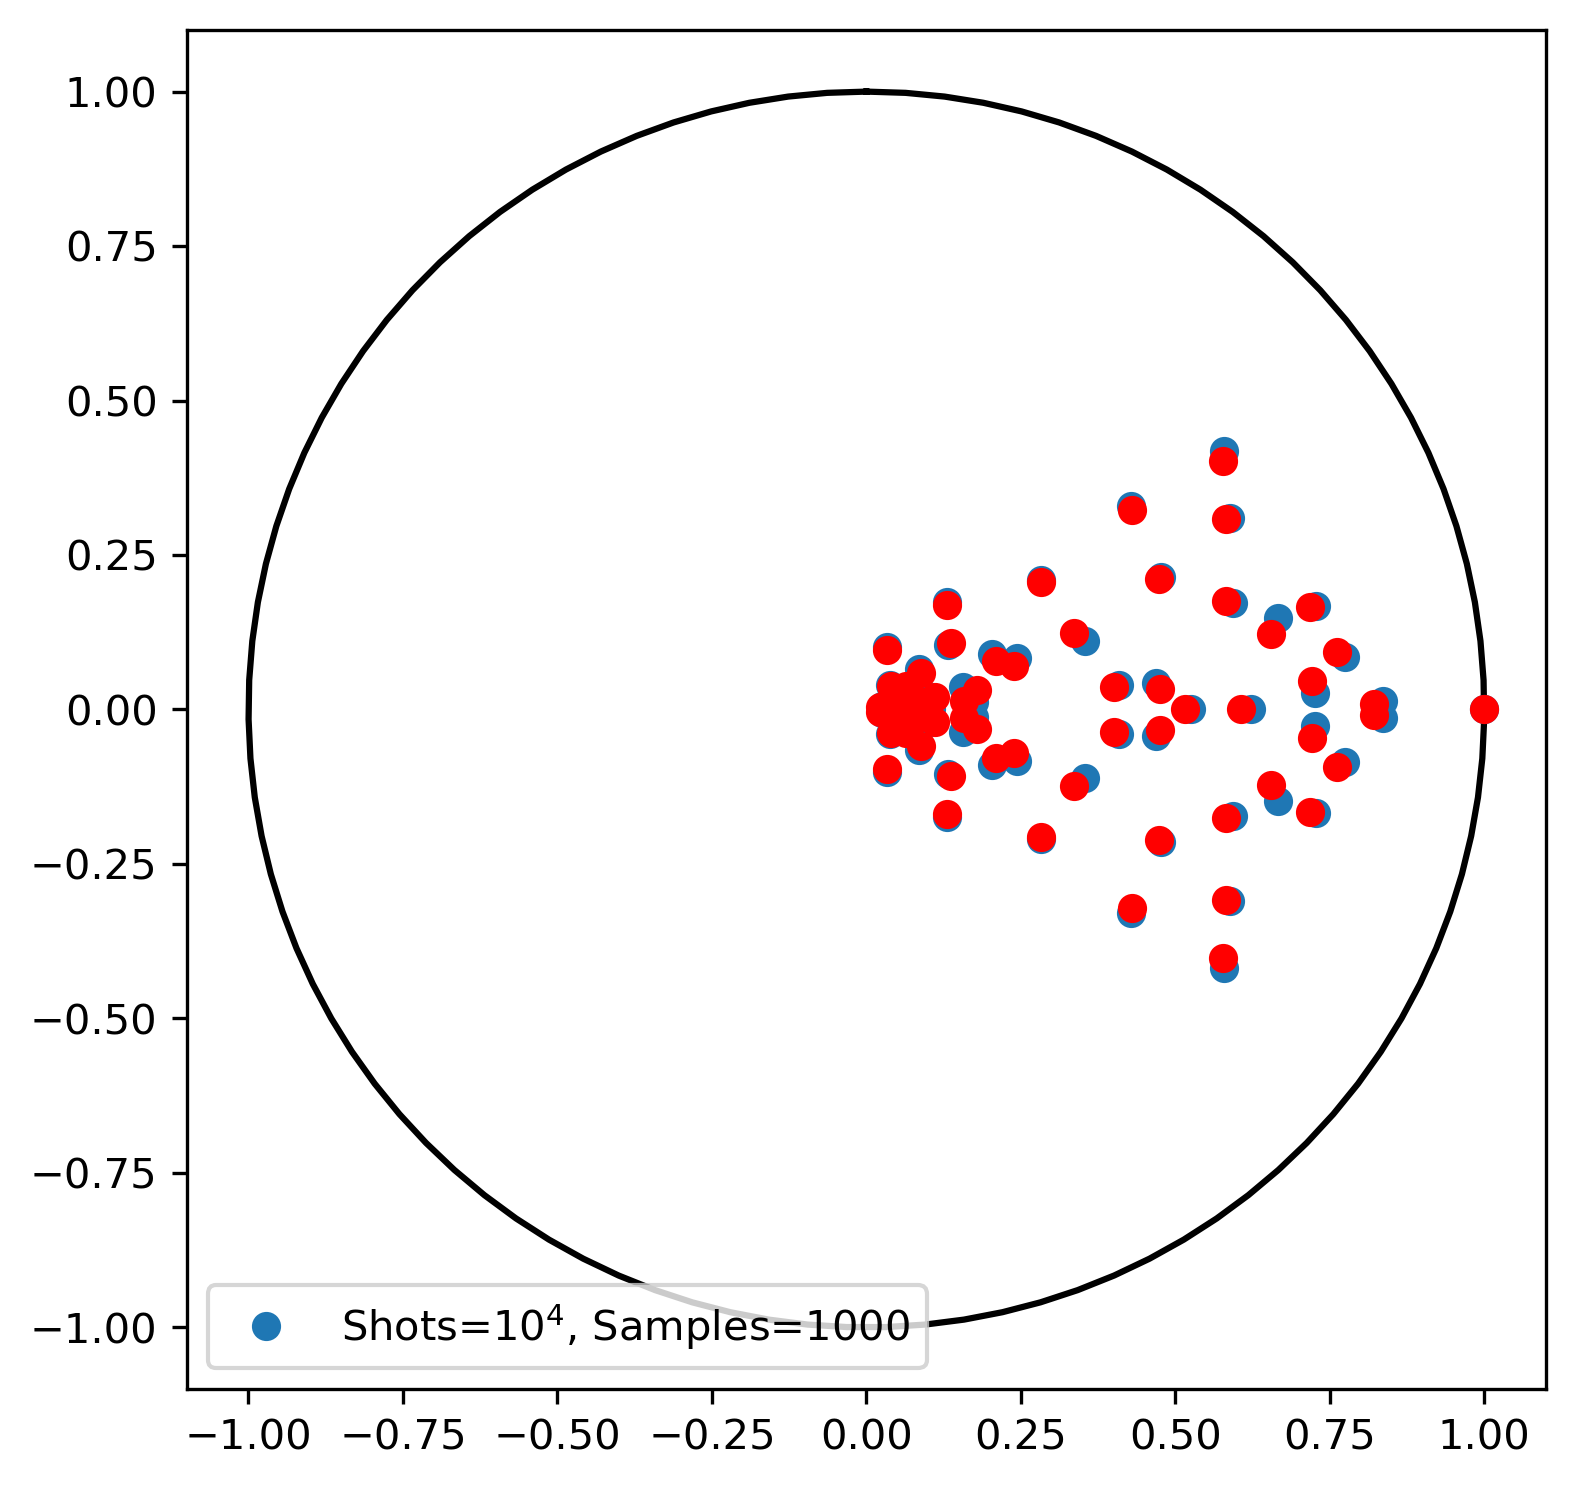

In [91]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum_target[:,0], spectrum_target[:,1], "o")
#plt.plot(spectrum_model1[:,0], spectrum_model1[:,1], "o")
plt.plot(spectrum_model2[:,0], spectrum_model2[:,1], "ro")
#plt.plot(spectrum_model3[:,0], spectrum_model3[:,1], "o")
plt.legend(["_","Shots=$10^4$, Samples=1000"], loc="lower left")
plt.show()

C:\Users\krist\AppData\Local\Temp\ipykernel_4564\1073430551.py:12: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001C5056B2530> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(["_","Ground Truth", "Shots=$\infty$, #Samples=4000"], loc="lower left")


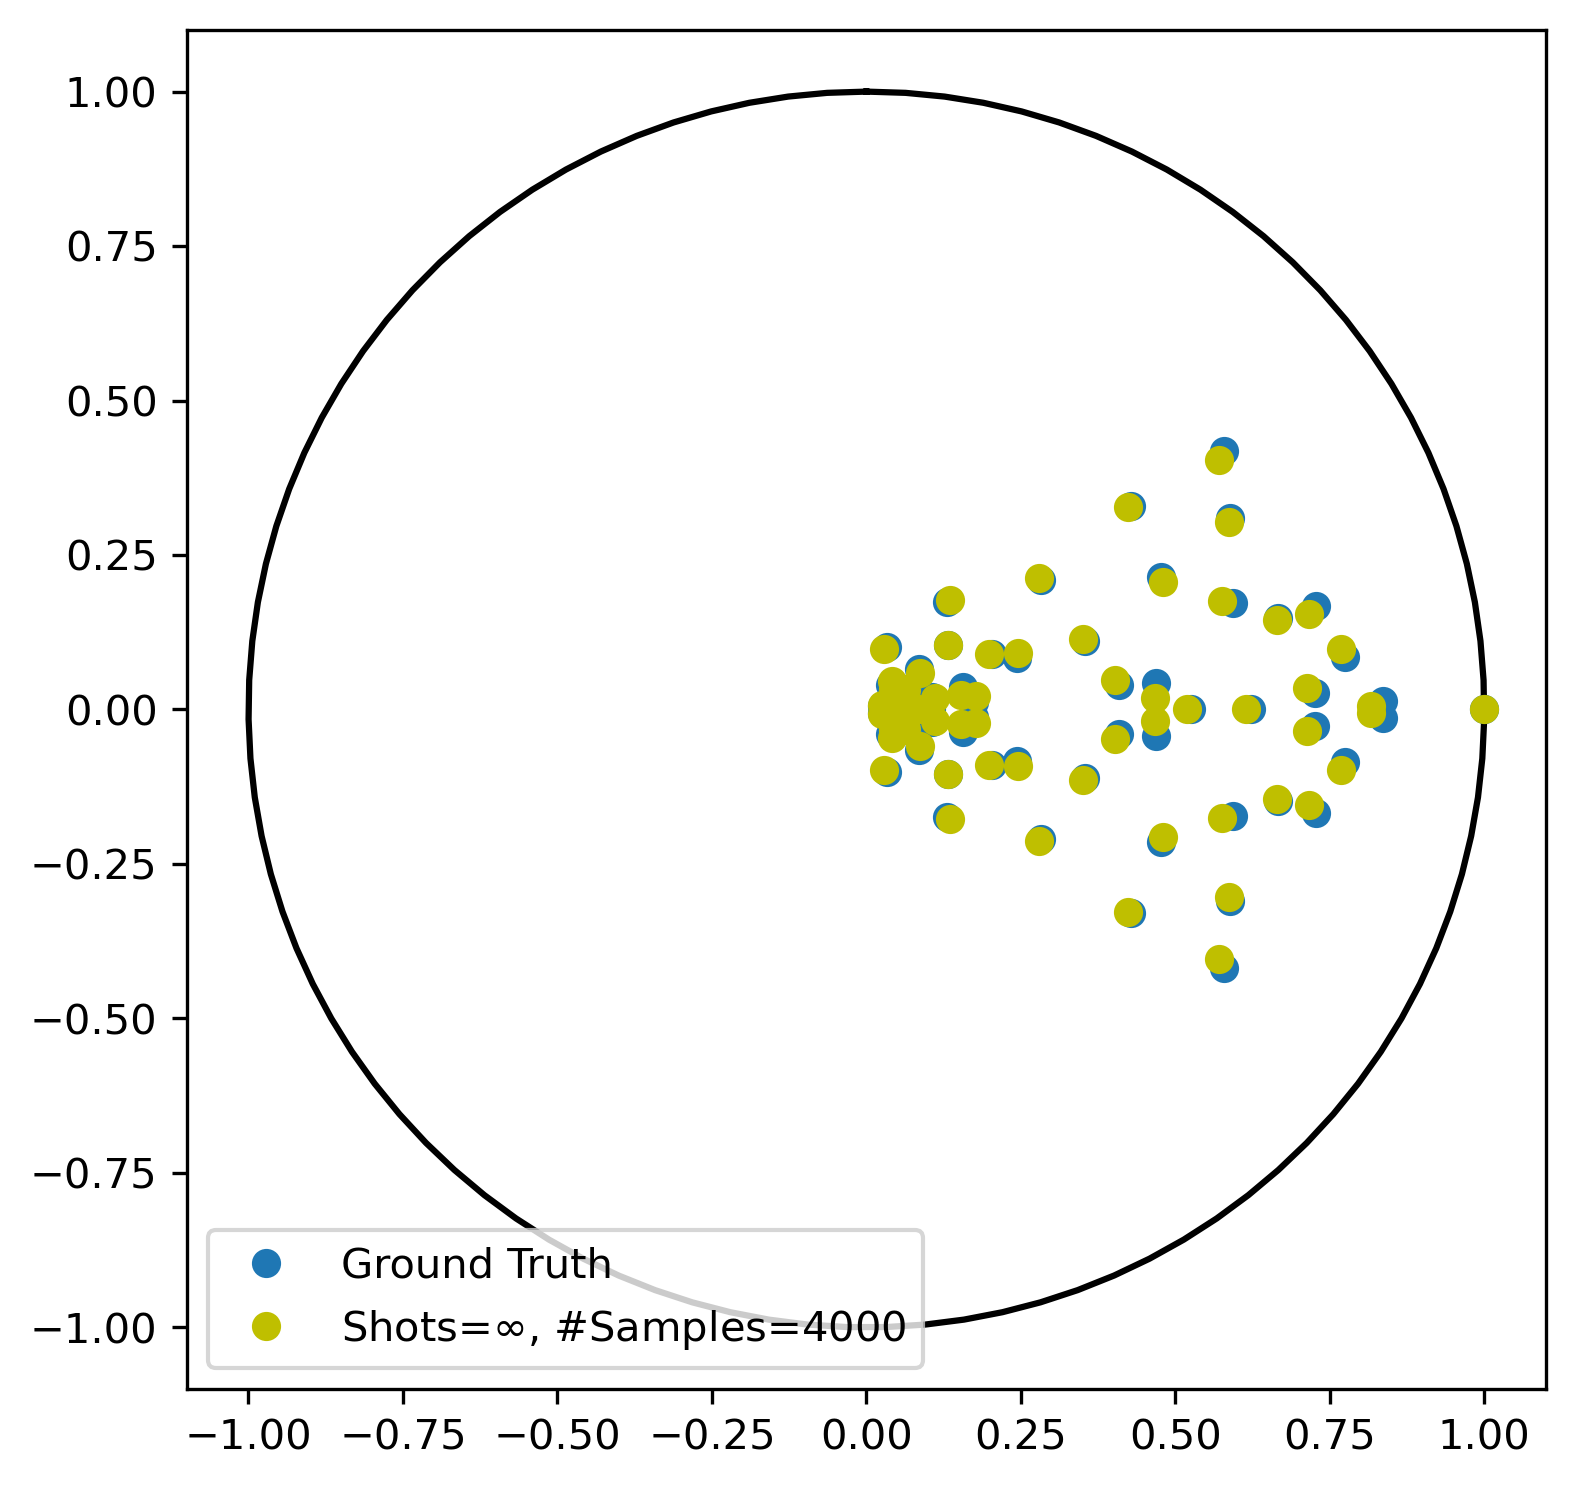

In [92]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum_target[:,0], spectrum_target[:,1], "o")
#plt.plot(spectrum_model1[:,0], spectrum_model1[:,1], "o")
#plt.plot(spectrum_model2[:,0], spectrum_model2[:,1], "o")
plt.plot(spectrum_model3[:,0], spectrum_model3[:,1], "yo")
plt.legend(["_","Ground Truth", "Shots=$\infty$, #Samples=4000"], loc="lower left")
plt.show()